In [2]:
# Dependencies are in requirments.txt
# list dependencies for this specific part
# imports!!
'''
transformers torch langchain sentence transformers pinecone
'''
import os
import faiss
import numpy as np
import pickle
import ollama
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("Welcome, please see 'data_processing_scripts/create_embeddings.ipynb' for method to embed queries.")
print("Database and associated chunks can be found here: data/RAG")
print("Read data_README.txt to understand file purposes")

Welcome, please see 'data_processing_scripts/create_embeddings.ipynb' for method to embed queries.
Database and associated chunks can be found here: data/RAG
Read data_README.txt to understand file purposes


## Grab clinical data for generation and retrieval

In [2]:
# TEXT chunks in data/RAG/chunks.pkl
# chunk embedding in Data/RAG/depression_embeddings.index
# mandatory txt in data/RAG/phq8.txt and data/RAG/mandatory_context_DSM5_MDD.txt

with open('data/RAG/chunks.pkl', 'rb') as f:
    chunks = pickle.load(f)

# Load FAISS index  
index = faiss.read_index('data/RAG/depression_embeddings.index')

# Load mandatory context
with open('data/RAG/phq8.txt', 'r', encoding='utf-8') as f:
    phq8 = f.read()
    
with open('data/RAG/mandatory_context_DSM5_MMD.txt', 'r', encoding='utf-8') as f:
    dsm5 = f.read()

print(f"Loaded {len(chunks)} chunks and index with {index.ntotal} vectors")
print(f"\nMandatory context loaded:")
print(f"  - PHQ-8: {len(phq8)} characters")
print(f"  - DSM-5: {len(dsm5)} characters")


Loaded 704 chunks and index with 704 vectors

Mandatory context loaded:
  - PHQ-8: 1517 characters
  - DSM-5: 15750 characters


## Load the Diac-Woz Dataset:

In [3]:
# Load DAIC-WOZ data with pre-computed embeddings
with open('data/RAG/diac_woz_data.pkl', 'rb') as f:
    daic_woz_data = pickle.load(f)

print("\n" + "="*80)
print("DAIC-WOZ Dataset Loaded")
print("="*80)
print(f"Number of patients: {len(daic_woz_data['patient_ids'])}")
print(f"Embeddings shape: {daic_woz_data['embeddings'].shape}")
print(f"\nAvailable keys: {list(daic_woz_data.keys())}")
print(f"\nFirst patient ID: {daic_woz_data['patient_ids'][0]}")
print(f"First conversation preview (first 200 chars): {daic_woz_data['conversations'][0][:200]}...")
print(f"First patient MDD binary label: {daic_woz_data['mdd_binary'][0]}")
print(f"First patient PHQ-8 score: {daic_woz_data['phq8_scores'][0]}")


DAIC-WOZ Dataset Loaded
Number of patients: 189
Embeddings shape: (189, 384)

Available keys: ['patient_ids', 'conversations', 'embeddings', 'mdd_binary', 'phq8_scores']

First patient ID: 300
First conversation preview (first 200 chars): speaker	value
Ellie	hi i'm ellie thanks for coming in today
Ellie	i was created to talk to people in a safe and secure environment
Ellie	think of me as a friend i don't judge i can't i'm a computer
El...
First patient MDD binary label: 0
First patient PHQ-8 score: 2


## Load llama 3B or gemma2:2b model

Must run this in terminal: ollama pull llama3.2:3b or ollama pull gemma2:2b

In [16]:
def llm(prompt):
    """Call Ollama with JSON format enforcement"""
    response = ollama.chat(
        model='llama3.2:3b',
        messages=[{'role': 'user', 'content': prompt}],
        format='json',  # 🔥 This forces JSON output!
        options={'temperature': 0}
    )
    return response['message']['content']

In [15]:
def parse_llm_response(response_text):
    """Parse and validate JSON response"""
    import json
    try:
        # Clean response
        response_text = response_text.strip()
        
        # Remove markdown code blocks if present
        if response_text.startswith('```'):
            response_text = response_text.split('```')[1]
            if response_text.startswith('json'):
                response_text = response_text[4:]
            response_text = response_text.strip()
        
        # Parse JSON
        result = json.loads(response_text)
        
        # Validate severity value
        valid_severities = ["none", "mild", "moderate", "moderate to severe", "severe"]
        severity = result.get("severity", "").lower()
        
        if severity not in valid_severities:
            print(f"⚠️ Invalid severity '{severity}', defaulting to 'UNKNOWN'")
            return "UNKNOWN"
        
        # Map to categories (keeping them distinct)
        severity_mapping = {
            "none": "NONE",
            "mild": "MILD",
            "moderate": "MODERATE",
            "moderate to severe": "MODERATE_TO_SEVERE",
            "severe": "SEVERE"
        }
        
        return severity_mapping[severity]
        
    except json.JSONDecodeError as e:
        print(f"❌ JSON parsing error: {e}")
        print(f"Raw response: {response_text[:200]}...")
        return "UNKNOWN"

## Build Retrieval Pipeline
create a function that takes diac woz convo and retrieves the top-k most relevant document chunks from clinical-rag database

top-K: try out 5-10

### input: user query (diac-woz convo) output: top-k relevant clinical data

In [6]:
def retrieval_pipeline(embedding, k=5):
    """
    Retrieve top-k most relevant clinical chunks using FAISS similarity search
    
    Args:
        embedding: numpy array of shape (384,) - conversation embedding
        k: int - number of top chunks to retrieve
    
    Returns:
        list of tuples: [(chunk_text, similarity_score, chunk_index), ...]
    """
    print("\n" + "="*80)
    print(f"RETRIEVAL PIPELINE - Searching for top-{k} relevant chunks")
    print("="*80)
    
    # Prepare embedding for FAISS (needs to be 2D and normalized)
    query_embedding = embedding.reshape(1, -1).astype('float32')
    faiss.normalize_L2(query_embedding)
    
    ## print(f"Query embedding shape: {query_embedding.shape}")
    
    # Search FAISS index
    distances, indices = index.search(query_embedding, k)
    
    ## print(f"\nTop {k} chunk indices: {indices[0]}")
    ## print(f"Similarity scores: {distances[0]}")
    
    # Retrieve actual chunk text
    retrieved_chunks = []
    for i, idx in enumerate(indices[0]):
        chunk_text = chunks[idx]
        similarity_score = distances[0][i]
        retrieved_chunks.append((chunk_text, similarity_score, idx))
        
       ### PRINT CHUNK FROM HERE
    
    return retrieved_chunks


## Generation pipeline
build the prompt that combines the retreived context with the diac woz convo  to fill out the form: read this convo: convo.... and this criteria: top-k criteria.... and return this sheet: possible symptoms:(...) and depression symptom severity(choose one: none, moderete, severe)


### Input: top-k relevant clinical data + Diac-woz conversation Output: prompt for RAG 

In [ ]:
def generation_pipeline(conversation, retrieved_chunks):
    """
    Build comprehensive prompt with conversation + mandatory context + retrieved chunks
    
    Args:
        conversation: str - DAIC-WOZ patient conversation
        retrieved_chunks: list of tuples - output from retrieval_pipeline
    
    Returns:
        str: Complete prompt for LLM
    """
    print("\n" + "="*80)
    print("GENERATION PIPELINE - Building prompt")
    print("="*80)
    
    # Format retrieved chunks
    retrieved_context = "\n\n".join([
        f"--- Retrieved Clinical Reference {i+1} (Similarity: {score:.4f}) ---\n{chunk}"
        for i, (chunk, score, idx) in enumerate(retrieved_chunks)
    ])
    
    # Build comprehensive prompt
    prompt = f"""<analysis_report>

Use the clinical_criteria to assess patient_conversations.

<clinical_criteria>
The following clinical criteria is NOT part of the patient_conversation.
The DSM5 requirements for Major Depressive Disorder: 
{dsm5}
and the explanation of symptom severity:
{phq8}
</clinical_criteria>

<patient_conversation>
Extract the Patient status from the following conversation: {conversation}
</patient_conversation>

<recommendation>
Determine if the Patient status from <patient_conversation> meets all the proper criteria from <clinical_criteria>.
</recommendation>

<form>
The severity of symptoms: (None, Mild, Moderate, Severe)
</form>

</analysis_report>
"""
    
    print(f"Prompt length: {len(prompt)} characters")
    print(f"Conversation length: {len(conversation)} characters")
    print(f"Number of retrieved chunks: {len(retrieved_chunks)}")
    
    return prompt

## Run the RAG model

given the Diac-Woz convo feed it through the retrival pipeline and pass it to the generation pipeline to retrieve the prompt for the RAG

rags_output = run the model with the prompt and save whole output

predicted label = run clean prompt to find classification label

### input: diac-woz convo Output: RAG's output, predicted label

In [18]:
def run_rag_pipeline(patient_idx, k=5):
    """
    Complete RAG pipeline with chain-of-thought reasoning
    """
    print("\n" + "="*80)
    print(f"RAG PIPELINE - Patient Index {patient_idx}")
    print("="*80)
    
    # Get patient data
    patient_id = daic_woz_data['patient_ids'][patient_idx]
    conversation = daic_woz_data['conversations'][patient_idx]
    embedding = daic_woz_data['embeddings'][patient_idx]
    true_mdd = daic_woz_data['mdd_binary'][patient_idx]
    true_phq8 = daic_woz_data['phq8_scores'][patient_idx]
    
    print(f"\nPatient ID: {patient_id}")
    print(f"True MDD Binary: {true_mdd}")
    print(f"True PHQ-8 Score: {true_phq8}")
    
    # Step 1: Retrieval
    retrieved_chunks = retrieval_pipeline(embedding, k=k)
    
    # Step 2: Generation with reasoning
    prompt = generation_pipeline_with_reasoning(conversation, retrieved_chunks)
    
    # Step 3: LLM call
    print("\n" + "="*80)
    print("Calling LLM for assessment...")
    print("="*80)
    
    raw_response = llm(prompt)
    predicted_severity, reasoning = parse_llm_response_with_reasoning(raw_response)
    
    print(f"\n🤔 REASONING: {reasoning}")
    print(f"\n✅ SEVERITY: {predicted_severity}")
    
    # Build results
    results = {
        'patient_id': patient_id,
        'true_mdd_binary': true_mdd,
        'true_phq8_score': true_phq8,
        'predicted_severity': predicted_severity,
        'reasoning': reasoning,
        'raw_llm_response': raw_response,
        'retrieved_chunks': retrieved_chunks,
        'conversation_length': len(conversation)
    }
    
    return results

## Test with Single Conversation
Run the complete pipeline on one patient to verify everything works

In [19]:
# Optional: Quick test on first 3 patients to verify it's working
def test_run_sample(n_patients=3, k=5):
    """
    Test the pipeline on first N patients to verify everything works
    """
    print("="*80)
    print(f"🧪 TEST RUN: Processing first {n_patients} patients")
    print("="*80 + "\n")
    
    test_results = {}
    
    for i in range(n_patients):
        try:
            patient_id = daic_woz_data['patient_ids'][i]
            conversation = daic_woz_data['conversations'][i]
            embedding = daic_woz_data['embeddings'][i]
            true_mdd = daic_woz_data['mdd_binary'][i]
            
            print(f"\n{'='*80}")
            print(f"Patient {i+1}/{n_patients}: {patient_id}")
            print(f"{'='*80}")
            
            # Retrieval
            retrieved_chunks = retrieval_pipeline(embedding, k=k)
            
            # Build prompt
            prompt = generation_pipeline(conversation, retrieved_chunks)
            
            # LLM call (individual for each patient)
            print(f"🤖 Making LLM call #{i+1}...")
            raw_response = llm(prompt)
            
            # Parse
            predicted = parse_llm_response(raw_response)
            
            print(f"\nTrue MDD: {true_mdd} | Predicted: {predicted}")
            
            test_results[patient_id] = {
                'true_mdd_binary': true_mdd,
                'predicted_severity': predicted,
                'raw_response': raw_response[:200]  # Just preview
            }
            
        except Exception as e:
            print(f"❌ Error: {e}")
    
    print(f"\n{'='*80}")
    print(f"✅ Test complete! Results:")
    print(f"{'='*80}")
    for pid, result in test_results.items():
        print(f"{pid}: True={result['true_mdd_binary']}, Pred={result['predicted_severity']}")
    
    return test_results

# Run test first
test_results = test_run_sample(n_patients=3, k=5)

🧪 TEST RUN: Processing first 3 patients


Patient 1/3: 300

RETRIEVAL PIPELINE - Searching for top-5 relevant chunks

GENERATION PIPELINE - Building prompt
Prompt length: 23985 characters
Conversation length: 5718 characters
Number of retrieved chunks: 5
🤖 Making LLM call #1...

True MDD: 0 | Predicted: MODERATE

Patient 2/3: 301

RETRIEVAL PIPELINE - Searching for top-5 relevant chunks

GENERATION PIPELINE - Building prompt
Prompt length: 29213 characters
Conversation length: 10946 characters
Number of retrieved chunks: 5
🤖 Making LLM call #2...

True MDD: 0 | Predicted: MODERATE

Patient 3/3: 302

RETRIEVAL PIPELINE - Searching for top-5 relevant chunks

GENERATION PIPELINE - Building prompt
Prompt length: 25342 characters
Conversation length: 7075 characters
Number of retrieved chunks: 5
🤖 Making LLM call #3...

True MDD: 0 | Predicted: MODERATE

✅ Test complete! Results:
300: True=0, Pred=MODERATE
301: True=0, Pred=MODERATE
302: True=0, Pred=MODERATE


CLASSIFICATION METRICS
Accuracy:    0.6190 (117/189)
Precision:   0.4149 (TP / (TP + FP))
Recall:      0.6964 (TP / (TP + FN))
Specificity: 0.5865 (TN / (TN + FP))
F1 Score:    0.5200

Confusion Matrix Values:
True Negatives:  78
False Positives: 55
False Negatives: 17
True Positives:  39

Detailed Classification Report:
               precision    recall  f1-score   support

No Depression       0.82      0.59      0.68       133
   Depression       0.41      0.70      0.52        56

     accuracy                           0.62       189
    macro avg       0.62      0.64      0.60       189
 weighted avg       0.70      0.62      0.64       189


Confusion matrix saved as 'confusion_matrix.png'


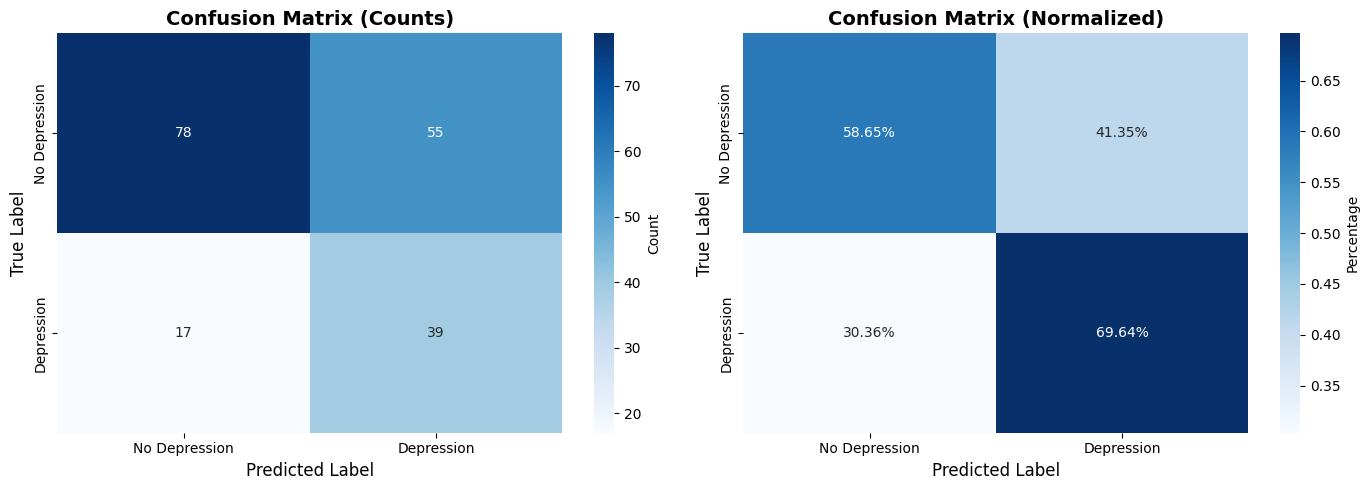

Performance metrics saved as 'performance_metrics.png'


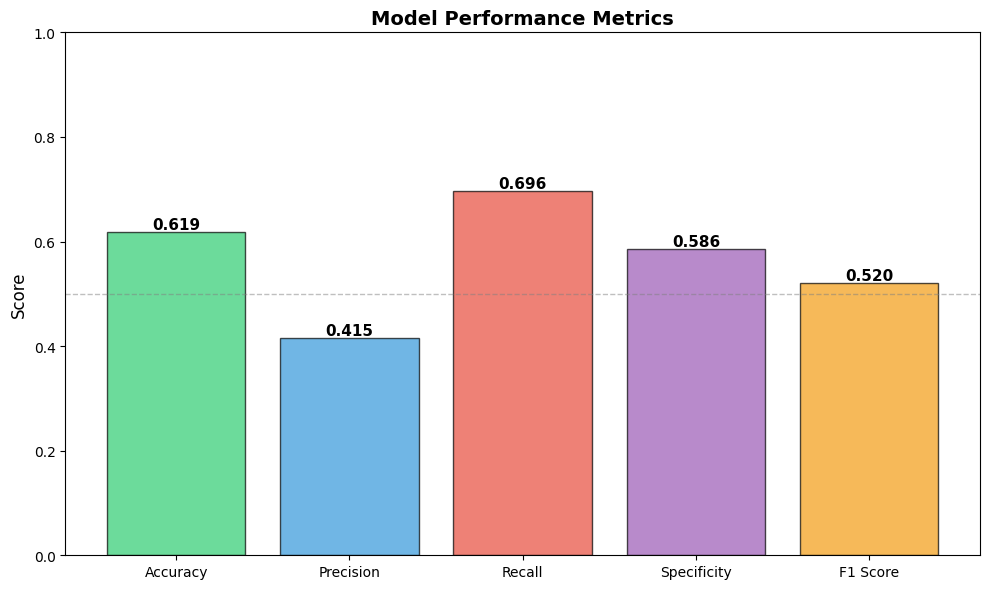

Metrics saved to 'model_metrics.txt'


In [3]:
# LLAMA Prompt engineering data (replace this with your output:)
data = """300: True=0, Pred=0
301: True=0, Pred=0
302: True=0, Pred=1
303: True=0, Pred=0
304: True=0, Pred=0
305: True=0, Pred=0
306: True=0, Pred=1
307: True=0, Pred=0
308: True=1, Pred=1
309: True=1, Pred=1
310: True=0, Pred=0
311: True=1, Pred=1
312: True=0, Pred=1
313: True=0, Pred=1
314: True=0, Pred=0
315: True=0, Pred=0
316: True=0, Pred=1
317: True=0, Pred=0
318: True=0, Pred=1
319: True=1, Pred=1
320: True=1, Pred=1
321: True=1, Pred=1
322: True=0, Pred=1
323: True=0, Pred=0
324: True=0, Pred=0
325: True=1, Pred=1
326: True=0, Pred=0
327: True=0, Pred=1
328: True=0, Pred=0
329: True=0, Pred=0
330: True=1, Pred=0
331: True=0, Pred=1
332: True=1, Pred=1
333: True=0, Pred=0
334: True=0, Pred=0
335: True=1, Pred=0
336: True=0, Pred=1
337: True=1, Pred=1
338: True=1, Pred=0
339: True=1, Pred=1
340: True=0, Pred=0
341: True=0, Pred=0
343: True=0, Pred=0
344: True=1, Pred=1
345: True=1, Pred=1
346: True=1, Pred=1
347: True=1, Pred=1
348: True=1, Pred=1
349: True=0, Pred=1
350: True=1, Pred=1
351: True=1, Pred=0
352: True=1, Pred=0
353: True=1, Pred=1
354: True=1, Pred=0
355: True=1, Pred=0
356: True=1, Pred=1
357: True=0, Pred=0
358: True=0, Pred=1
359: True=1, Pred=1
360: True=0, Pred=0
361: True=0, Pred=0
362: True=1, Pred=0
363: True=0, Pred=0
364: True=0, Pred=0
365: True=1, Pred=1
366: True=0, Pred=1
367: True=1, Pred=1
368: True=0, Pred=0
369: True=0, Pred=0
370: True=0, Pred=0
371: True=0, Pred=0
372: True=1, Pred=1
373: True=0, Pred=0
374: True=0, Pred=1
375: True=0, Pred=0
376: True=1, Pred=1
377: True=1, Pred=1
378: True=0, Pred=0
379: True=0, Pred=0
380: True=1, Pred=0
381: True=1, Pred=1
382: True=0, Pred=0
383: True=0, Pred=0
384: True=1, Pred=1
385: True=0, Pred=0
386: True=1, Pred=1
387: True=0, Pred=0
388: True=1, Pred=1
389: True=1, Pred=1
390: True=0, Pred=1
391: True=0, Pred=1
392: True=0, Pred=1
393: True=0, Pred=0
395: True=0, Pred=1
396: True=0, Pred=1
397: True=0, Pred=0
399: True=0, Pred=1
400: True=0, Pred=1
401: True=0, Pred=0
402: True=1, Pred=0
403: True=0, Pred=1
404: True=0, Pred=1
405: True=1, Pred=0
406: True=0, Pred=0
407: True=0, Pred=0
408: True=0, Pred=0
409: True=0, Pred=1
410: True=1, Pred=0
411: True=0, Pred=1
412: True=1, Pred=1
413: True=1, Pred=0
414: True=1, Pred=1
415: True=0, Pred=1
416: True=0, Pred=1
417: True=0, Pred=1
418: True=1, Pred=1
419: True=0, Pred=1
420: True=0, Pred=1
421: True=1, Pred=1
422: True=1, Pred=1
423: True=0, Pred=0
424: True=0, Pred=0
425: True=0, Pred=0
426: True=1, Pred=1
427: True=0, Pred=1
428: True=0, Pred=1
429: True=0, Pred=0
430: True=0, Pred=0
431: True=0, Pred=0
432: True=0, Pred=0
433: True=1, Pred=1
434: True=0, Pred=1
435: True=0, Pred=0
436: True=0, Pred=1
437: True=0, Pred=0
438: True=0, Pred=0
439: True=0, Pred=0
440: True=1, Pred=0
441: True=1, Pred=1
442: True=0, Pred=0
443: True=0, Pred=1
444: True=0, Pred=1
445: True=0, Pred=1
446: True=0, Pred=1
447: True=0, Pred=0
448: True=1, Pred=0
449: True=0, Pred=0
450: True=0, Pred=1
451: True=0, Pred=1
452: True=0, Pred=0
453: True=1, Pred=0
454: True=0, Pred=0
455: True=0, Pred=0
456: True=0, Pred=1
457: True=0, Pred=0
458: True=0, Pred=1
459: True=1, Pred=1
461: True=1, Pred=0
462: True=0, Pred=0
463: True=0, Pred=1
464: True=0, Pred=0
465: True=0, Pred=0
466: True=0, Pred=0
467: True=0, Pred=1
468: True=0, Pred=1
469: True=0, Pred=1
470: True=0, Pred=0
471: True=0, Pred=0
472: True=0, Pred=1
473: True=0, Pred=1
474: True=0, Pred=0
475: True=0, Pred=1
476: True=0, Pred=0
477: True=0, Pred=0
478: True=0, Pred=0
479: True=0, Pred=1
480: True=0, Pred=0
481: True=0, Pred=1
482: True=0, Pred=1
483: True=1, Pred=1
484: True=0, Pred=0
485: True=0, Pred=0
486: True=0, Pred=1
487: True=0, Pred=0
488: True=0, Pred=1
489: True=0, Pred=1
490: True=0, Pred=0
491: True=0, Pred=0
492: True=0, Pred=0
"""

# Parse the data
true_labels = []
pred_labels = []

for line in data.strip().split('\n'):
    parts = line.split(': ')[1].split(', ')
    true_val = int(parts[0].split('=')[1])
    pred_val = int(parts[1].split('=')[1])
    true_labels.append(true_val)
    pred_labels.append(pred_val)

# Convert to numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(pred_labels)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print metrics
print("=" * 50)
print("CLASSIFICATION METRICS")
print("=" * 50)
print(f"Accuracy:    {accuracy:.4f} ({tp + tn}/{len(y_true)})")
print(f"Precision:   {precision:.4f} (TP / (TP + FP))")
print(f"Recall:      {recall:.4f} (TP / (TP + FN))")
print(f"Specificity: {specificity:.4f} (TN / (TN + FP))")
print(f"F1 Score:    {f1:.4f}")
print("=" * 50)
print("\nConfusion Matrix Values:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")
print("=" * 50)

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Depression', 'Depression']))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix with counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'],
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Plot 2: Normalized Confusion Matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'],
            cbar_kws={'label': 'Percentage'}, ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Create a metrics bar plot
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
values = [accuracy, precision, recall, specificity, f1]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
print("Performance metrics saved as 'performance_metrics.png'")
plt.show()

# Save metrics to text file
with open('model_metrics.txt', 'w') as f:
    f.write("=" * 50 + "\n")
    f.write("DEPRESSION DETECTION MODEL METRICS\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Total Samples: {len(y_true)}\n")
    f.write(f"Positive Cases: {sum(y_true)} ({sum(y_true)/len(y_true)*100:.1f}%)\n")
    f.write(f"Negative Cases: {len(y_true) - sum(y_true)} ({(len(y_true)-sum(y_true))/len(y_true)*100:.1f}%)\n\n")
    f.write("=" * 50 + "\n")
    f.write("PERFORMANCE METRICS\n")
    f.write("=" * 50 + "\n")
    f.write(f"Accuracy:    {accuracy:.4f}\n")
    f.write(f"Precision:   {precision:.4f}\n")
    f.write(f"Recall:      {recall:.4f}\n")
    f.write(f"Specificity: {specificity:.4f}\n")
    f.write(f"F1 Score:    {f1:.4f}\n\n")
    f.write("=" * 50 + "\n")
    f.write("CONFUSION MATRIX\n")
    f.write("=" * 50 + "\n")
    f.write(f"True Negatives:  {tn}\n")
    f.write(f"False Positives: {fp}\n")
    f.write(f"False Negatives: {fn}\n")
    f.write(f"True Positives:  {tp}\n\n")
    f.write("=" * 50 + "\n")
    f.write(classification_report(y_true, y_pred, target_names=['No Depression', 'Depression']))

print("Metrics saved to 'model_metrics.txt'")